In [1]:
from cadcad.spaces import space
from cadcad.dynamics import block
from cadcad.spaces import Bit, Real, Integer, EmptySpace
from cadcad.points import Point
from cadcad.systems import Experiment
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
@space
class CartesianPlane:
    x:float
    y:float

In [3]:
@space
class Particle:
    pos:CartesianPlane
    vel:CartesianPlane
    # used to encode a constraint
    #but this is exactly the kind of thing
    #i would like to push into the model params
    maxspeed : float

In [4]:
@space
class ObservedParticle:
    pos:CartesianPlane
    prev:CartesianPlane

In [5]:
from enum import Enum
class Strategy(Enum):
    EVADE: -1
    PURSUE: 1

print(Strategy.__annotations__)


{'EVADE': -1, 'PURSUE': 1}


In [6]:

@space
class Agent:
    plant: Particle
    reference: ObservedParticle
    strategy: Strategy

In [7]:

#this block serves as a kind of constraint checker for Particle
#i would like to be able to assign this block to the Space Paricle
#as a builtin constraint
@block
def isValidParticle(domain:Point[Particle])-> Point[Bit]:
    input = deepcopy(domain)
    dx= input['vel']['x']
    dy= input['vel']['y']

    vmax = input['maxspeed']

    output = {'bit':bool(dx**2+dy**2<=vmax**2)}

    return Point(Bit, output)

In [8]:
@block
def projectValidParticle(domain:Point[Particle])-> Point[Particle]:
    input = deepcopy(domain)

    bit = isValidParticle(input)
    output = input
    if not(bit['bit']):
        dx= input['vel']['x']
        dy= input['vel']['y']
        magnitude = np.sqrt(dx**2+dy**2)
        output['vel']['x'] = input['maxspeed']*dx/magnitude
        output['vel']['y'] = input['maxspeed']*dy/magnitude
      
    return output

In [9]:
ParticleUpdateDomain = (Particle * CartesianPlane).rename_dims({'cartesianplane':"acc"})

In [10]:
@block
def particleSubspace(domain: Point[ParticleUpdateDomain])-> Point[Particle]:
    input = deepcopy(domain)
    return Point(Particle, input.data['particle'])

In [11]:
@block
def particleUpdate(domain:Point[ParticleUpdateDomain])-> Point[Particle]:
    input = deepcopy(domain)
    output = particleSubspace(input)

    output['pos']['x']  += input['particle']['vel']['x']
    output['pos']['y']  += input['particle']['vel']['y']

    output['vel']['x']  += input['acc']['x']
    output['vel']['y']  += input['acc']['y']

    output = projectValidParticle(output)

    return output

In [12]:
@block
def randomPoint(domain:Point[EmptySpace])-> Point[CartesianPlane]:
    data = {}
    data['x'] = .005+np.random.randn()/5.0
    data['y'] = .005+np.random.randn()/5.0

    return Point(CartesianPlane, data)

@block
def randomWalk(domain:Point[CartesianPlane])-> Point[CartesianPlane]:
    input = domain
    data = {}
    data['x'] = input['x']+.005+np.random.randn()/5.0
    data['y'] = input['y']+.005+np.random.randn()/5.0

    return Point(CartesianPlane, data)

In [13]:
emptyPoint = Point(EmptySpace,{})

In [14]:
myPoint = randomPoint(emptyPoint)
print(myPoint)

Point in space CartesianPlane has data
{
    "x": 0.25842382923639345,
    "y": 0.020952866618036015
}



In [15]:
experiment_params = {"iteration_n": 2, "steps": 25}
my_experiment = Experiment(myPoint, experiment_params, (randomWalk,))

results = my_experiment.run()

In [16]:
def flattenHer(results, exp_params):
    n = exp_params["iteration_n"]
    m = exp_params["steps"]
    dfs = []
    for j in range(n):
        d = results[j].data
        r = np.zeros((m,2))
        for i in range(m):

            r[i,:]= [d[i]['x'], d[i]['y']]
        df = pd.DataFrame(r, columns=['x','y'])
        df["run"]  = j
        df['dx'] = df.x.diff().shift(-1)
        df['dy'] = df.y.diff().shift(-1)
        dfs.append(df)

    return pd.concat(dfs)

In [17]:
df=flattenHer(results, experiment_params)

In [18]:
df.head()

,x,y,run,dx,dy
0,0.621736,0.183719,0,0.196910,-0.035472
1,0.818646,0.148247,0,0.219268,-0.082801
2,1.037914,0.065446,0,-0.059539,0.060031
3,0.978375,0.125478,0,-0.277273,0.217753
4,0.701102,0.343231,0,0.220331,0.118947


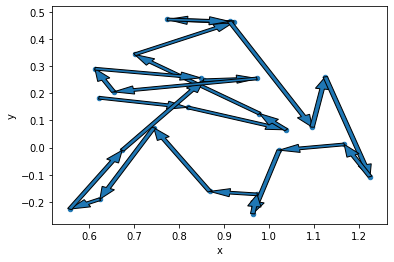

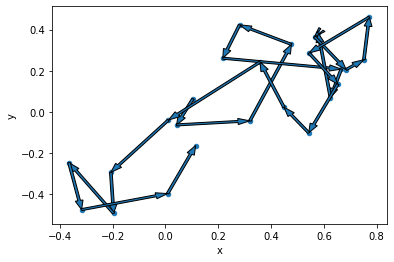

In [19]:
runs = df.run.unique()
for k in runs:
    df[df.run==k].plot(x="x", y='y',kind="scatter")
    r = df[df.run==k].drop('run',axis=1).values
    n = len(r)
    for i in range(n):
        plt.arrow(*r[i,:4], width = 0.01, 
        length_includes_head=True)

In [20]:
Agent.unroll_schema()

{'plant': {'pos': {'x': 'float', 'y': 'float'},
  'vel': {'x': 'float', 'y': 'float'},
  'maxspeed': 'float'},
 'reference': {'pos': {'x': 'float', 'y': 'float'},
  'prev': {'x': 'float', 'y': 'float'}},
 'strategy': 'Strategy'}

In [21]:
@block
def aliceDecision(domain:Point[Agent])->Point[CartesianPlane]:
    alice = deepcopy(domain)
    targetx = alice['reference']['pos']['x']
    targety = alice['reference']['pos']['y']
    
    errorx = alice['plant']['pos']['x']-targetx
    errory = alice['plant']['pos']['y']-targety

    ##WIP

@block
def aliceDynamics(domain:Point[Agent])->Point[Agent]:
    alice = deepcopy(domain)
    acc = randomWalk(emptyPoint)
    
    arg_data = {}
    arg_data['particle'] = alice.data
    arg_data['acc'] = acc.data

    args = Point(ParticleUpdateDomain, arg_data)

    output = particleUpdate(args)

    return output

In [22]:
emptyPoint = Point(EmptySpace,{})



In [23]:
Particle.unroll_schema()

{'pos': {'x': 'float', 'y': 'float'},
 'vel': {'x': 'float', 'y': 'float'},
 'maxspeed': 'float'}

In [24]:
initAlice = Point(Particle, {'pos': {'x': 0.0, 'y': 0.0},
 'vel': {'dx': -1.0, 'dy': -1.0},
 'maxspeed': .2})

experiment_params = {"iteration_n": 5, "steps": 25}
my_experiment = Experiment(initAlice, experiment_params, (aliceDynamics,))

results = my_experiment.run()

ValueError: Schema mismatch between the Point's Space and the data given. Expected {'pos': <class 'cadcad.spaces.space.<locals>.NewSpace'>, 'vel': <class 'cadcad.spaces.space.<locals>.NewSpace'>, 'maxspeed': <class 'float'>}, but received ["pos -> <class 'dict'>", "vel -> <class 'dict'>", "maxspeed -> <class 'float'>"]

In [ ]:
results

In [ ]:
def flattenHer(results, exp_params):
    n = exp_params["iteration_n"]
    m = exp_params["steps"]
    dfs = []
    for j in range(n):
        d = results[j].data
        r = np.zeros((m,4))
        for i in range(m):

            r[i,:]= [d[i]['pos']['x'], d[i]['pos']['y'],d[i]['vel']['dx'], d[i]['vel']['dy']]
        df = pd.DataFrame(r, columns=['x','y','dx','dy'])
        df["run"]  = j
        dfs.append(df)

    return pd.concat(dfs)

In [ ]:
df = flattenHer(results,experiment_params)

In [ ]:
df

NameError: name 'df' is not defined

In [ ]:
runs = df.run.unique()
for k in runs:
    df[df.run==k].plot(x="x", y='y',kind="scatter")
    r = df[df.run==k].values
    n = len(r)
    for i in range(n):
        plt.arrow(*r[i,:4], width = 0.01, 
        length_includes_head=True)

NameError: name 'df' is not defined